## 2.6.7 （CoLab部分）NAIP航拍影像与分割模型库及Colaboratory和Planetary Computer Hub

### 2.6.7.3 （CoLab）航拍影像语义分割


In [2]:
%pip install torchgeo
%pip install matplotlib==3.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.1/279.1 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 569.1/569.1 KB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 KB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 KB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.3/800.3 KB 61.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 88.2 MB/s eta 0:00:00
     ━━━━━━━━

In [3]:
!pip show torchgeo

Name: torchgeo
Version: 0.3.1
Summary: TorchGeo: datasets, samplers, transforms, and pre-trained models for geospatial data
Home-page: https://github.com/microsoft/torchgeo
Author: Adam J. Stewart
Author-email: ajstewart426@gmail.com
License: 
Location: /usr/local/lib/python3.8/dist-packages
Requires: einops, fiona, kornia, matplotlib, numpy, omegaconf, packaging, pillow, pyproj, pytorch-lightning, rasterio, rtree, scikit-learn, segmentation-models-pytorch, shapely, timm, torch, torchmetrics, torchvision
Required-by: 


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
import os
imagery_data=os.path.join('/content/gdrive/MyDrive/data/delaware', "imagery")
LC_data=os.path.join('/content/gdrive/MyDrive/data/delaware', "LC")
data_dir=os.path.join('/content/gdrive/MyDrive/data/delaware', "training")

In [6]:
naipEntityID_selection_fn=r'/content/gdrive/MyDrive/data/delaware/naipEntityID_selection.txt'
with open(naipEntityID_selection_fn,'r') as f:
    naipEntityID_selection=f.readlines()
naipEntityID_selection=[line.rstrip() for line in naipEntityID_selection]   
naipEntityID_selection

['m_3807505_se_18_060_20180827.tif',
 'm_3807505_sw_18_060_20180815.tif',
 'm_3807504_se_18_060_20180815.tif',
 'm_3807504_sw_18_060_20180815.tif']

In [7]:
from torchvision.datasets.utils import download_url
naip_38075_url=("https://naipeuwest.blob.core.windows.net/naip/v002/de/2018/de_060cm_2018/38075/")

naip_download_rul=lambda url,tile,root:download_url(url+tile,root)
for tile in naipEntityID_selection:
    try:
        naip_download_rul(naip_38075_url,tile,imagery_data)
    except:
        print(f'Can not access to:{tile}')

Using downloaded and verified file: /content/gdrive/MyDrive/data/delaware/imagery/m_3807505_se_18_060_20180827.tif
Using downloaded and verified file: /content/gdrive/MyDrive/data/delaware/imagery/m_3807505_sw_18_060_20180815.tif
Using downloaded and verified file: /content/gdrive/MyDrive/data/delaware/imagery/m_3807504_se_18_060_20180815.tif
Using downloaded and verified file: /content/gdrive/MyDrive/data/delaware/imagery/m_3807504_sw_18_060_20180815.tif


In [8]:
chesapeakebay_landcover_url="https://cicwebresources.blob.core.windows.net/chesapeakebaylandcover"
base_folder="DE"
zipfile="_DE_STATEWIDE.zip"
chesapeakebay_landcover_url += f"/{base_folder}/{zipfile}"

In [9]:
download_url(chesapeakebay_landcover_url, LC_data, filename=zipfile) 

Using downloaded and verified file: /content/gdrive/MyDrive/data/delaware/LC/_DE_STATEWIDE.zip


In [5]:
# 迁移于TorchGeo库：torchgeo.datasets.utils模块
import tarfile
from typing import (
    Any,
    Dict,
    Iterable,
    Iterator,
    List,
    Optional,
    Sequence,
    Tuple,
    Union,
    cast,
    overload,
)

class _rarfile:
    class RarFile:
        def __init__(self, *args: Any, **kwargs: Any) -> None:
            self.args = args
            self.kwargs = kwargs

        def __enter__(self) -> Any:
            try:
                import rarfile
            except ImportError:
                raise ImportError(
                    "rarfile is not installed and is required to extract this dataset"
                )

            # TODO: catch exception for when rarfile is installed but not
            # unrar/unar/bsdtar
            return rarfile.RarFile(*self.args, **self.kwargs)

        def __exit__(self, exc_type: None, exc_value: None, traceback: None) -> None:
            pass


class _zipfile:
    class ZipFile:
        def __init__(self, *args: Any, **kwargs: Any) -> None:
            self.args = args
            self.kwargs = kwargs

        def __enter__(self) -> Any:
            try:
                # Supports normal zip files, proprietary deflate64 compression algorithm
                import zipfile_deflate64 as zipfile
            except ImportError:
                # Only supports normal zip files
                # https://github.com/python/mypy/issues/1153
                import zipfile  # type: ignore[no-redef]

            return zipfile.ZipFile(*self.args, **self.kwargs)

        def __exit__(self, exc_type: None, exc_value: None, traceback: None) -> None:
            pass


def extract_archive(src: str, dst: Optional[str] = None) -> None:
    """Extract an archive.

    Args:
        src: file to be extracted
        dst: directory to extract to (defaults to dirname of ``src``)

    Raises:
        RuntimeError: if src file has unknown archival/compression scheme
    """
    if dst is None:
        dst = os.path.dirname(src)

    suffix_and_extractor: List[Tuple[Union[str, Tuple[str, ...]], Any]] = [
        (".rar", _rarfile.RarFile),
        (
            (".tar", ".tar.gz", ".tar.bz2", ".tar.xz", ".tgz", ".tbz2", ".tbz", ".txz"),
            tarfile.open,
        ),
        (".zip", _zipfile.ZipFile),
    ]

    for suffix, extractor in suffix_and_extractor:
        if src.endswith(suffix):
            with extractor(src, "r") as f:
                f.extractall(dst)
            return

    suffix_and_decompressor: List[Tuple[str, Any]] = [
        (".bz2", bz2.open),
        (".gz", gzip.open),
        (".xz", lzma.open),
    ]

    for suffix, decompressor in suffix_and_decompressor:
        if src.endswith(suffix):
            dst = os.path.join(dst, os.path.basename(src).replace(suffix, ""))
            with decompressor(src, "rb") as sf, open(dst, "wb") as df:
                df.write(sf.read())
            return

    raise RuntimeError("src file has unknown archival/compression scheme")

In [11]:
extract_archive(os.path.join(LC_data, zipfile))

In [148]:
# 迁移于TorchGeo库：torchgeo.datamodules.naip模块

def chesapeake_transform(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Transform a single sample from the Chesapeake Dataset.

    Args:
        sample: Chesapeake mask dictionary

    Returns:
        preprocessed Chesapeake data
    """
    sample["mask"] = sample["mask"].long()[0]

    return sample

def remove_bbox(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Removes the bounding box property from a sample.

    Args:
        sample: dictionary with geographic metadata

    Returns
        sample without the bbox property
    """
    del sample["bbox"]
    return sample

def labes_merge(sample: Dict[str, Any]) -> Dict[str, Any]:

    label_merge_mapping={1:1, # Water ->Water
                        2:2, # Emergent Wetlands -> Emergent Wetlands
                        3:3, # Tree Canopy -> Tree Canopy
                        4:4, # Scrub/Shrub -> Scrub/Shrub
                        5:4, # Low Vegetation -> Scrub/Shrub
                        6:5, # Barren -> Barren(6->5)
                        7:6, # Impervious Structures -> Impervious Structures(7->6)
                        8:6, # Other Impervious -> Impervious Structures(7->6)
                        9:7, # Impervious Road -> Impervious Road(9->7)
                        10:3, # Tree Canopy over Impervious Structure -> Tree Canopy
                        11:3, # Tree Canopy over Other Impervious -> Tree Canopy
                        12:3, # Tree Canopy over Impervious Roads -> Tree Canopy
                        254:8, # Aberdeen Proving Ground -> Aberdeen Proving Ground(254->8)
                        }
    old=sample["mask"]
    #print('-'*50)
    #print(old.shape)
    indexer=np.array([label_merge_mapping.get(i, -1) for i in range(old.min(), old.max() + 1)])
    new=torch.from_numpy(indexer[(old - old.min())])
    #print(new.shape)
    sample["mask"]=new
    #print('-'*50)
    return sample

In [149]:
from torchvision.transforms import Compose
from torchgeo.datasets import RasterDataset

chesapeak_transforms=Compose([chesapeake_transform,remove_bbox,labes_merge])

class delaware_lc_rd(RasterDataset):
    filename_glob="DE_STATEWIDE.tif"
    is_image=False

chesapeake=delaware_lc_rd(LC_data,transforms=chesapeak_transforms) 

In [56]:
print(f"crs:{chesapeake.crs}\nres:{chesapeake.res}")

crs:ESRI:102039
res:1.0


In [57]:
from torchgeo.transforms import AugmentationSequential, indices
import kornia.augmentation as K

def naip_preprocess(sample: Dict[str, Any]) -> Dict[str, Any]:
    """Transform a single sample from the NAIP Dataset.

    Args:
        sample: NAIP image dictionary

    Returns:
        preprocessed NAIP data
    """
    sample["image"] = sample["image"].float()
    sample["image"] /= 255.0

    return sample

class naip_rd(RasterDataset):
    filename_glob = "m_*.*"
    filename_regex = r"""
        ^m
        _(?P<quadrangle>\d+)
        _(?P<quarter_quad>[a-z]+)
        _(?P<utm_zone>\d+)
        _(?P<resolution>\d+)
        _(?P<date>\d+)
        (?:_(?P<processing_date>\d+))?
        \..*$
    """
    is_image=True

naip_transforms=Compose([naip_preprocess,remove_bbox,indices.AppendNDVI(index_nir=3, index_red=0),indices.AppendNDWI(index_green=1, index_nir=3)])
naip=naip_rd(imagery_data,chesapeake.crs,chesapeake.res,naip_transforms)

In [58]:
print(f"crs:{naip.crs}\nres:{naip.res}")

crs:ESRI:102039
res:1.0


In [ ]:
from torchgeo.transforms import AugmentationSequential, indices
import kornia.augmentation as K
import torch

augmentations=AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    # K.RandomAffine(degrees=(0, 90), p=0.25),
    # K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0), p=0.25),
    # K.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), p=0.25),
    data_keys=["image",'mask'],
)
transforms=torch.nn.Sequential(
    indices.AppendNDVI(index_nir=3, index_red=0),
    indices.AppendNDWI(index_green=1, index_nir=3),
    augmentations,
)

In [151]:
dataset=chesapeake & naip

In [152]:
from torchgeo.samplers import RandomGeoSampler
from torchgeo.datasets import stack_samples 
from torch.utils.data import DataLoader

sampler=RandomGeoSampler(dataset,size=256, length=100)
dataloader=DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

dataloader=iter(dataloader)
#plt.imshow(T.ToPILImage()(batch['image'][0][:3]));
#batch=transforms(batch)

In [61]:
import matplotlib
print(matplotlib.__version__)

3.6.2


In [20]:
%pip install matplotlib==3.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib
print(matplotlib.__version__)

3.6.2


torch.Size([1, 6, 256, 256])
torch.Size([1, 6, 256, 256])


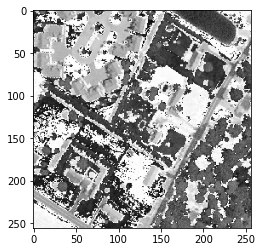

In [153]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

batch=next(dataloader)
print(batch['image'].shape)
print(batch['image'].shape)
plt.imshow(T.ToPILImage()(batch['image'][0][4:]));

In [154]:
batch['mask']

tensor([[[4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4],
         ...,
         [4, 4, 4,  ..., 3, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4]]])

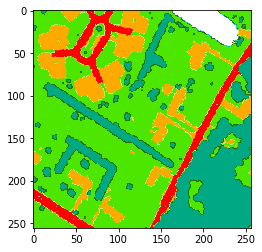

In [155]:
import matplotlib
import numpy as np

LC_color_dict={
    0: (0, 0, 0, 0),
    1: (0, 197, 255, 255),
    2: (0, 168, 132, 255),
    3: (38, 115, 0, 255),
    4: (76, 230, 0, 255),
    5: (163, 255, 115, 255),
    6: (255, 170, 0, 255),
    7: (255, 0, 0, 255),
    8: (156, 156, 156, 255),
    #9: (0, 0, 0, 255),
    #10: (115, 115, 0, 255),
    #11: (230, 230, 0, 255),
    #12: (255, 255, 115, 255),
    #13: (197, 0, 255, 255),
    }

cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(LC_color_dict.keys()),[[v/255 for v in i] for i in LC_color_dict.values()],extend='max')
plt.imshow(np.squeeze(batch['mask']),cmap=cmap_LC);

In [105]:
batch['mask']

[array([[3, 3, 3, ..., 4, 4, 4],
        [3, 3, 3, ..., 4, 4, 4],
        [3, 3, 3, ..., 4, 4, 4],
        ...,
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4],
        [4, 4, 4, ..., 4, 4, 4]])]

In [106]:
a=batch['mask']

In [107]:
a.unique()

AttributeError: ignored

In [ ]:
label_merge_mapping={1:1, # Water ->Water
                     2:2, # Emergent Wetlands -> Emergent Wetlands
                     3:3, # Tree Canopy -> Tree Canopy
                     4:4, # Scrub/Shrub -> Scrub/Shrub
                     5:4, # Low Vegetation -> Scrub/Shrub
                     6:6, # Barren -> Barren
                     7:7, # Impervious Structures -> Impervious Structures
                     8:7, # Other Impervious -> Impervious Structures
                     9:9, # Impervious Road -> Impervious Road
                     10:3, # Tree Canopy over Impervious Structure -> Tree Canopy
                     11:3, # Tree Canopy over Other Impervious -> Tree Canopy
                     12:3, # Tree Canopy over Impervious Roads -> Tree Canopy
                     254:254, # Aberdeen Proving Ground -> Aberdeen Proving Ground
                     }

In [53]:
label_merge_mapping={1:1, # Water ->Water
                     2:2, # Emergent Wetlands -> Emergent Wetlands
                     3:3, # Tree Canopy -> Tree Canopy
                     4:4, # Scrub/Shrub -> Scrub/Shrub
                     5:4, # Low Vegetation -> Scrub/Shrub
                     6:5, # Barren -> Barren(6->5)
                     7:6, # Impervious Structures -> Impervious Structures(7->6)
                     8:6, # Other Impervious -> Impervious Structures(7->6)
                     9:7, # Impervious Road -> Impervious Road(9->7)
                     10:3, # Tree Canopy over Impervious Structure -> Tree Canopy
                     11:3, # Tree Canopy over Other Impervious -> Tree Canopy
                     12:3, # Tree Canopy over Impervious Roads -> Tree Canopy
                     254:254, # Aberdeen Proving Ground -> Aberdeen Proving Ground
                     }
                     
indexer=np.array([label_merge_mapping.get(i, -1) for i in range(a.min(), a.max() + 1)])
b=indexer[(a - a.min())]
b

array([[[3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [3, 3, 3, ..., 4, 4, 4],
        [3, 3, 3, ..., 4, 4, 4],
        [3, 3, 3, ..., 4, 4, 4]]])

In [156]:
# 迁移并更新于TorchGeo库：torchgeo.datamodules.naip模块

import pytorch_lightning as pl
import torchgeo
from torch.utils.data import DataLoader
import torch
from torchgeo.datasets import BoundingBox,stack_samples
from torchgeo.samplers.batch import RandomBatchGeoSampler
from torchgeo.samplers.single import GridGeoSampler


class geo_datamodule(pl.LightningDataModule):
    """LightningDataModule implementation for the TorchGeo datasets.

    Uses the train/val/test splits from the dataset.
    """  
    # TODO: tune these hyperparams
    length=1000
    stride=128

    def __init__(
        self,
        ds_image: torchgeo.datasets,
        ds_label: str,
        batch_size: int=64,
        num_workers: int=0,
        patch_size: int=256,
        transforms: torch.nn.modules.container.Sequential=None,
        **kwargs: Any,
    ) -> None:
        """Initialize a LightningDataModule for TorchGeo dataset based DataLoaders.

        Args:
            dataset:
            batch_size: The batch size to use in all created DataLoaders
            num_workers: The number of workers to use in all created DataLoaders
            patch_size: size of patches to sample
        """
        super().__init__()
        self.ds_image=ds_image
        self.ds_label=ds_label
        self.transforms=transforms
        self.batch_size=batch_size
        self.num_workers=num_workers
        self.patch_size=patch_size    

    def setup(self, stage: Optional[str] = None) -> None:
        """Initialize the main ``Dataset`` objects.

        This method is called once per GPU per run.

        Args:
            stage: state to set up
        """
        # TODO: these transforms will be applied independently, this won't work if we
        # add things like random horizontal flip

        # TODO: figure out better train/val/test split
        self.dataset = self.ds_label & self.ds_image
        if self.transforms:
            self.dataset.tranforms=self.transforms

        roi=self.dataset.bounds
        midx=roi.minx + (roi.maxx - roi.minx) / 2
        midy=roi.miny + (roi.maxy - roi.miny) / 2
        train_roi=BoundingBox(roi.minx, midx, roi.miny, roi.maxy, roi.mint, roi.maxt)
        val_roi=BoundingBox(midx, roi.maxx, roi.miny, midy, roi.mint, roi.maxt)
        test_roi=BoundingBox(roi.minx, roi.maxx, midy, roi.maxy, roi.mint, roi.maxt)

        self.train_sampler=RandomBatchGeoSampler(
            self.ds_image, self.patch_size, self.batch_size, self.length, train_roi
        )
        self.val_sampler = GridGeoSampler(self.ds_image, self.patch_size, self.stride, val_roi)
        self.test_sampler = GridGeoSampler(self.ds_image, self.patch_size, self.stride, test_roi)

    def train_dataloader(self) -> DataLoader[Any]:
        """Return a DataLoader for training.

        Returns:
            training data loader
        """   

        return DataLoader(
            self.dataset,
            batch_sampler=self.train_sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        """Return a DataLoader for validation.

        Returns:
            validation data loader
        """

        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            sampler=self.val_sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        """Return a DataLoader for testing.

        Returns:
            testing data loader
        """

        return DataLoader(            
            self.dataset,
            batch_size=self.batch_size,
            sampler=self.test_sampler,
            num_workers=self.num_workers,
            collate_fn=stack_samples,
        ) 

In [157]:
from torchgeo.transforms import AugmentationSequential, indices
import kornia.augmentation as K

augmentations=AugmentationSequential(
    K.RandomHorizontalFlip(p=0.5),
    K.RandomVerticalFlip(p=0.5),
    # K.RandomAffine(degrees=(0, 90), p=0.25),
    # K.RandomGaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0), p=0.25),
    # K.RandomResizedCrop(size=(512, 512), scale=(0.8, 1.0), p=0.25),
    data_keys=["image"],
)
transforms=torch.nn.Sequential(
    indices.AppendNDVI(index_nir=3, index_red=0),
    indices.AppendNDWI(index_green=1, index_nir=3),
    augmentations,
)

datamodule=geo_datamodule(
    ds_image=naip,
    ds_label=chesapeake,
    #transforms=transforms,
    batch_size=64,#64, 
    patch_size=256 
    )

In [159]:
from torchgeo.trainers import SemanticSegmentationTask

aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.5,               # dropout ratio, default is None
    activation='sigmoid',      # activation function, default is None
    classes=8,                 # define number of output labels
)

task=SemanticSegmentationTask(
    segmentation_model='unet', 
    encoder_name='resnet34',
    encoder_weights='imagenet',
    pretrained=True,
    in_channels=6,
    num_classes=8,
    ignore_index=7,
    loss='ce', # 'ce','jaccard'
    learning_rate=0.1,
    learning_rate_schedule_patience=5,
    ignore_zeros=True,
    aux_params=aux_params,
    )

In [161]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

checkpoint_callback=ModelCheckpoint(monitor="val_loss", dirpath=data_dir, save_top_k=1, save_last=True) #,save_on_train_epoch_end=True
early_stopping_callback=EarlyStopping(monitor="val_loss", min_delta=0.00, patience=10)
csv_logger=CSVLogger(save_dir=data_dir, name="segmentation_unet")
in_tests="PYTEST_CURRENT_TEST" in os.environ

trainer=pl.Trainer(
    callbacks=[checkpoint_callback,early_stopping_callback], 
    logger=[csv_logger],
    default_root_dir=data_dir,
    min_epochs=1,
    max_epochs=300,
    fast_dev_run=in_tests,
    accelerator="gpu",   
    #limit_val_batches=500,
    #val_check_interval=1,
    #devices=2,
    #strategy="ddp_notebook",
    #check_val_every_n_epoch=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [162]:
from os import path

ckpt_path=os.path.join(data_dir,'last.ckpt')
if path.exists(ckpt_path):
    print('ckpt file exists.')
    trainer.fit(model=task,datamodule=datamodule,ckpt_path=ckpt_path)  
else:
    trainer.fit(model=task,datamodule=datamodule)

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /content/gdrive/MyDrive/data/delaware/training exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Unet             | 24.4 M
1 | loss          | CrossEntropyLoss | 0     
2 | train_metrics | MetricCollection | 0     
3 | val_metrics   | MetricCollection | 0     
4 | test_metrics  | MetricCollection | 0     
---------------------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.787    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(
/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (15) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 8. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
 %pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 KB 7.7 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29741 sha256=72451a4b718dc50cd2a63a0aa1eec0b07144648d54b1edc3d84a495591613617
  Stored in directory: /root/.cache/pip/wheels/b7/d8/5b/d765b9e8b0c00c0a902ef97f86fe44b9f82ead731c3fb732c9
  Created wheel for visdom: filename=visdom-0.2.3-py3-none-any.whl size=1417107 sha256=591964421529122e2b3013d3ff33e4d2ff808919ef9722bdf5d7c02406236142
  Stored in directory: /root/.cache/pip/wheels/4d/73/32/0bbe55d2dccb9d80d3f020f474c15a5a1eef232817dcebe776
Successfully built torchnet visdom


In [164]:
import csv

if not in_tests:
    train_steps = []
    train_rmse = []

    val_steps = []
    val_rmse = []
    with open(
        os.path.join(data_dir, "segmentation_unet", "version_0", "metrics.csv"), "r"  #"version_3"
    ) as f:
        csv_reader = csv.DictReader(f, delimiter=",")
        for i, row in enumerate(csv_reader):
            try:
                train_rmse.append(float(row["train_loss"]))
                train_steps.append(i)
            except ValueError:  # Ignore rows where train RMSE is empty
                pass

            try:
                val_rmse.append(float(row["val_Accuracy"]))
                val_steps.append(i)
            except ValueError:  # Ignore rows where val RMSE is empty
                pass

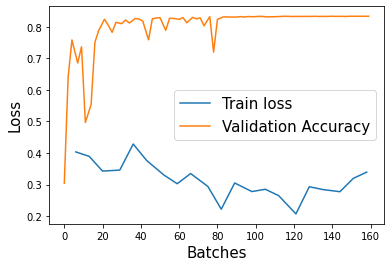

In [165]:
import matplotlib.pyplot as plt

if not in_tests:
    plt.figure()
    plt.plot(train_steps, train_rmse, label="Train loss")
    plt.plot(val_steps, val_rmse, label="Validation Accuracy")
    plt.legend(fontsize=15)
    plt.xlabel("Batches", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.show()
    plt.close()

In [166]:
trainer.test(model=task, datamodule=datamodule)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 12. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_Accuracy         0.8202915191650391
    test_JaccardIndex       0.2725767493247986
        test_loss           0.5870120525360107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5870120525360107,
  'test_Accuracy': 0.8202915191650391,
  'test_JaccardIndex': 0.2725767493247986}]

In [184]:
from torchgeo.samplers import GridGeoSampler,RandomGeoSampler
from torchgeo.datasets import NAIP,stack_samples
from torch.utils.data import DataLoader
import torch

X_pre=NAIP(r'/content/gdrive/MyDrive/data/delaware_imagery_temp',transforms=naip_transforms)
#X_sample=RandomGeoSampler(X_pre, size=1024, length=10) # 
X_sample=RandomGeoSampler(X_pre, size=1024,length=100) 
X_dataloader=DataLoader(X_pre, sampler=X_sample, collate_fn=stack_samples)

#for batch in X_dataloader:
    #image=batch["image"]
    #break

X_dataloader_=iter(X_dataloader)

In [204]:
X_batch=next(X_dataloader_)
X=X_batch["image"]#.float()

In [ ]:
#print(X.shape,'\n',X)

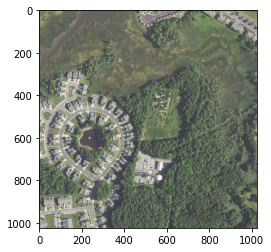

In [205]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

plt.imshow(T.ToPILImage()(X[0][:3]));

In [174]:
unet_model=task.load_from_checkpoint(os.path.join(data_dir,'last.ckpt'))
unet_model.freeze()

In [208]:
y_probs=unet_model(X)
print(y_probs.shape)

torch.Size([1, 8, 1024, 1024])


In [209]:
import numpy as np
y_pred=np.argmax(y_probs,axis=1)#.reshape(-1,1)
print(y_pred.shape,'\n',y_pred,'\n',y_pred.unique())

torch.Size([1, 1024, 1024]) 
 tensor([[[4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 4, 4, 4],
         [4, 4, 4,  ..., 6, 4, 4],
         ...,
         [6, 6, 6,  ..., 4, 4, 4],
         [4, 4, 6,  ..., 4, 4, 4],
         [4, 4, 6,  ..., 4, 4, 4]]]) 
 tensor([3, 4, 6])


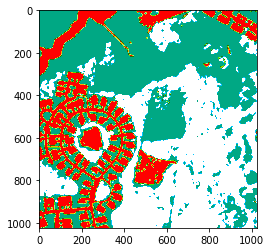

In [210]:
import matplotlib
import numpy as np

LC_color_dict={
    0: (0, 0, 0, 0),
    1: (0, 197, 255, 255),
    2: (0, 168, 132, 255),
    3: (38, 115, 0, 255),
    4: (76, 230, 0, 255),
    5: (163, 255, 115, 255),
    6: (255, 170, 0, 255),
    7: (255, 0, 0, 255),
    8: (156, 156, 156, 255),
   # 9: (0, 0, 0, 255),
    #10: (115, 115, 0, 255),
    #11: (230, 230, 0, 255),
    #12: (255, 255, 115, 255),
    #13: (197, 0, 255, 255),
    }

cmap_LC, norm=matplotlib.colors.from_levels_and_colors(list(LC_color_dict.keys()),[[v/255 for v in i] for i in LC_color_dict.values()],extend='max')
plt.imshow(np.squeeze(y_pred),cmap=cmap_LC);